Description: Jupyter notebook for carrying out learning experiments with HAL-FI on the simulator

In [1]:
# Imports
import os, sys, types
import pathlib

In [2]:
# Add paths
import itertools
import math
import sympy
import numpy as np
import scipy.linalg
import scipy.stats
import scipy.optimize
import scipy.fftpack

import tensorflow  as  tf
tf.compat.v1.enable_eager_execution(config=None, device_policy=None, execution_mode=None)

#import seaborn as sns
#import pandas as pd
import matplotlib.pyplot as plt
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score

import pickle

from importlib import reload
from sympy.physics.quantum.dagger import Dagger

In [3]:
# Local package imports
# Update this with setup & develop later
PROJECT_PATH = str(pathlib.Path().resolve().parent)
sys.path.append(PROJECT_PATH)

In [4]:
import hamiltonianlearner

Instructions for updating:
non-resource variables are not supported in the long term


In [5]:
import hamiltonianlearner.quantum_system_oracles.process_data as process_data
import hamiltonianlearner.quantum_system_oracles.simulate_nature as simulate_nature
import hamiltonianlearner.quantum_system_models.quantum_device_models as quantum_device_models
import hamiltonianlearner.learners.design_experiment as design_experiment

In [6]:
# estimators
import hamiltonianlearner.estimators.initial_estimators as initial_estimators
import hamiltonianlearner.estimators.mle_estimators as mle_estimators
import hamiltonianlearner.estimators.estimation_procedure as estimation_procedure

In [7]:
# For plotting purposes
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [8]:
# global configuration flags
from absl import app
from absl import flags
reload(flags)
FLAGS = flags.FLAGS

if "verbose" not in dir(FLAGS):
  flags.DEFINE_boolean('verbose', True, "generate verbose debugging output")
  flags.DEFINE_boolean('limit_search_space', False, "truncate MLE search space")
  
FLAGS(['verbose'])

['verbose']

In [9]:
import yaml
#import unit_tests

In [10]:
import functools

In [11]:
import hamiltonianlearner.utils.learner_experiment_utils as learner_experiment_utils
import hamiltonianlearner.utils.job_helper as job_helper

In [12]:
# Cool reloading
# Reference: https://stackoverflow.com/questions/28101895/reloading-packages-and-their-submodules-recursively-in-python

def reload_package(package):
    assert(hasattr(package, "__package__"))
    fn = package.__file__
    fn_dir = os.path.dirname(fn) + os.sep
    module_visit = {fn}
    del fn

    def reload_recursive_ex(module):
        reload(module)

        for module_child in vars(module).values():
            if isinstance(module_child, types.ModuleType):
                fn_child = getattr(module_child, "__file__", None)
                if (fn_child is not None) and fn_child.startswith(fn_dir):
                    if fn_child not in module_visit:
                        # print("reloading:", fn_child, "from", module)
                        module_visit.add(fn_child)
                        reload_recursive_ex(module_child)

    return reload_recursive_ex(package)

#### Global parameters/constants

In [13]:
def kron(a, b):
    return np.matrix(scipy.linalg.kron(a, b))

In [14]:
si = np.array([ [1, 0], [0, 1] ])
sx = np.array([ [0, 1], [1, 0] ])
sy = np.array([ [0, -1j], [1j, 0] ])
sz = np.array([ [1, 0], [0, -1] ])

# According to Ed's slides and answers verified -- match!
moset = {0: [si,scipy.linalg.expm(1j*(np.pi/4)*sy)], 1: [si,scipy.linalg.expm(-1j*(np.pi/4)*sx)], 2: [si,si]}
prepset = {0: [si, si], 1: [sx, si]}

In [15]:
# Time Stamps similar to data
time_stamps = np.linspace(1e-7,6e-7,81)

### Parameters of interest

In [16]:
# ibmq_boeblingen data

# Parameters of the different jobs
meas_level_expt = 1
n_shots = 512
n_job = 1
cr_amp_array = [0.24, 0.30, 0.36, 0.42, 0.48]

In [17]:
ind_amp = 1
pickle_result_filename = 'ibmq_boel_fixed_qs_data_aligned_A_0_%d_meas_%d_shots_%d_job_%d.pickle' % (100*cr_amp_array[ind_amp], meas_level_expt,
                                                                           n_shots, n_job)
pickle_result_file = 'Data/ibmq_boel/'+pickle_result_filename

In [18]:
# Readout calibration and formatting again
ibm_data = process_data.make_dataset_ibmq_device(pickle_result_file, FLAG_classification=True, do_plot=False)

In [19]:
ibm_data['misclassif_error']

[0.0078125, 0.033203125]

# 1. Minimum Freq. Criteria is satisfied

In [20]:
# Setup oracle -- simulator
print('Using J_num which we already discovered before!')
J_truth = np.array([-4568258.88132824, -1465045.02848701,  -290468.97835928,
                    6499545.9801579 ,  1390900.08768167,   413722.74870734])

param_truth = quantum_device_models.transform_parameters(J_truth)

## Oracle properties
FLAG_simulator = True

## Noise Models
FLAG_readout_noise = False
FLAG_control_noise = True

# Control Noise
teff = quantum_device_models.data_driven_teff_noise_model(param_truth, FLAG_ibmq_boel=True)
expt_noise ={'readout':ibm_data['misclassif_error'], 'imperfect_pulse_shaping':teff}

# Create oracle
env_qs_sim = simulate_nature.Nature(J_truth, noise=expt_noise, expt_data=None,
                                FLAG_simulator=FLAG_simulator,
                                FLAG_readout_noise=FLAG_readout_noise,
                                FLAG_control_noise=FLAG_control_noise)

Using J_num which we already discovered before!
Simulator oracle setup


In [21]:
env_qs_sim.print_info()

Oracle: Simulator
Noise Sources:
Readout Noise: FLAG=False, Value=[0. 0.]
Control Noise: FLAG=True


In [22]:
xi_J = 10**np.amax(np.floor(np.log10(np.abs(J_truth))))*np.ones(len(J_truth))
xi_t = 1e-7

# Below one works has potential to work better for a hybrid solver
#xi_J = 10**(np.floor(np.log10(np.abs(J_truth))) + 1)

## 1.1 HAL-FI with Estimator of Linear Regression

We will be using the job helper functions.

In [23]:
reload_package(hamiltonianlearner)

In [24]:
# Setup the action space as in the fixed query space
time_stamps_nd = np.linspace(1,18,3*81)
time_stamps = xi_t*time_stamps_nd
A_cr = simulate_nature.Action_Space(moset, prepset, time_stamps_nd, xi_t, xi_J=xi_J)

In [25]:
np.pi/param_truth[0]/xi_t

16.391175948149083

In [26]:
# Illustration of different freq_converts
print("freq_convert from sim: %f" %A_cr.freq_convert)
print("freq_convert from expt data: %f" %ibm_data['freq_convert'])

freq_convert from sim: 3680781.516188
freq_convert from expt data: 12466637.514245


In [27]:
query_space = {'moset': moset, 'prepset': prepset, 'time_stamps': time_stamps}

In [32]:
# 2. Define the learning experiment using HAL-FI
policy_type = 'FI'
FLAG_normalization = True
FLAG_noise = True
growth_time_stamps=None
FLAG_constraints = True

query_constraints_ref = {'N_shots': 512}
FLAG_lower_limits = False

HAL_FI_J = design_experiment.ActiveLearner(policy_type=policy_type,
                                           FLAG_normalization=FLAG_normalization,
                                           FLAG_noise=FLAG_noise,
                                           FLAG_constraints=FLAG_constraints,
                                           query_constraints=query_constraints_ref,
                                           type_param = 'J')

# 3. Define estimator
est_param_info = {'freq_convert': A_cr.freq_convert, 'xi_t': A_cr.xi_t, 'xi_J': A_cr.xi_J, 'init_J': None}
estimation_strategy = {'baseline': True,
                       'quick_MLE': False,
                       'FLAG_initial_estimate': False, 
                       'FLAG_FFT_high_resolution': False,
                       'FLAG_MLE_param': False, 
                       'FLAG_MLE_J': False}

# 4. Define experiment runner
FLAG_query_constraints = True
query_constraints_info = {'query_constraints_ref': None, 'query_optimization_type': 'batch', 'max_iter': 10}
FLAG_adaptive_query_space = False
adaptive_query_space_info = {'growth_time_stamps': 'linear', 'max_iter_growth': 1, 'growth_factor': 1}

AL_baseline_expt = learner_experiment_utils.Learning_Experiment_Runner(env_cr=env_qs_sim,
                               query_space=query_space, est_param_info=est_param_info, active_learner=HAL_FI_J,
                               FLAG_query_constraints=FLAG_query_constraints, 
                               query_constraints_info=query_constraints_info,
                               estimation_strategy=estimation_strategy,
                               FLAG_adaptive_query_space=FLAG_adaptive_query_space, 
                               adaptive_query_space_info=adaptive_query_space_info,
                               N_0=5*A_cr.N_actions, N_batch=A_cr.N_actions)

In [33]:
i_run = 8
np.random.seed(10 * (i_run + 2))
results_expt01 = AL_baseline_expt.AL_runner(verbose=True)

Using baseline estimator
Solving with query constraints
Upper limits being set
Using baseline estimator
Solving with query constraints
Upper limits being set
Using baseline estimator
Solving with query constraints
Upper limits being set
Using baseline estimator
Solving with query constraints
Upper limits being set
Using baseline estimator
Solving with query constraints
Upper limits being set
Using baseline estimator
Solving with query constraints
Upper limits being set
Using baseline estimator
Solving with query constraints
Upper limits being set
Using baseline estimator
Solving with query constraints
Upper limits being set
Using baseline estimator
Solving with query constraints
Upper limits being set
Using baseline estimator
Solving with query constraints
Upper limits being set
Using baseline estimator


In [34]:
results_expt01.keys()

dict_keys(['loss', 'mse', 'J_hat', 'J_truth', 'xi_J', 'N_p', 'q', 'n_shots', 'data', 'A_cr'])

In [35]:
results_expt01['loss']

[0.6024888562662734,
 0.6138529792544499,
 0.6260131967852882,
 0.6329014457883625,
 0.6380589486978948,
 0.6428609085123297,
 0.6448495019313277,
 0.6481137632094841,
 0.6506094825095551,
 0.6523977728582738,
 0.6536745910039757]

In [36]:
results_expt01['mse']

[0.19911853005763352,
 0.22537584003963204,
 0.1879283693301612,
 0.1558102093467637,
 0.13439665036335247,
 0.12182782576325428,
 0.1422053452910219,
 0.18474445340211082,
 0.13434983739039158,
 0.14235125349135413,
 0.12814307601145547]

In [37]:
results_expt01['N_p']

[7290, 8748, 10206, 11664, 13122, 14580, 16038, 17496, 18954, 20412, 21870]

In [38]:
results_expt01['J_hat']

[array([-4472955.41433339, -1162166.530387  ,  -221761.64832858,
         6309817.45997405,  1151912.84900952,   335211.32784202]),
 array([-4476967.50592275, -1151232.60967496,  -173260.77135001,
         6313933.68128471,  1146477.77240094,   285380.37078406]),
 array([-4469671.21954321, -1189557.93943901,  -180294.86589816,
         6305576.44109657,  1174578.87707733,   307832.26293363]),
 array([-4461415.32026796, -1222875.99799484,  -196436.90516517,
         6297389.43411753,  1208507.8164468 ,   323049.5076658 ]),
 array([-4455479.62330519, -1236303.75473093,  -234166.10524853,
         6291234.53121987,  1230076.54437853,   364562.74016329]),
 array([-4450018.84537124, -1264141.84275813,  -216964.18407915,
         6285516.90624356,  1257595.90779773,   350912.53885864]),
 array([-4458168.74941204, -1234877.21441319,  -218172.21981523,
         6293850.64529541,  1215935.41842974,   348369.48541499]),
 array([-4470452.60692174, -1178826.20476062,  -233434.44551732,
         63

In [39]:
J_truth

array([-4573872.71813216, -1456459.93269852,  -297217.75625596,
        6486501.41598311,  1397617.03924571,   406234.05359476])

In [40]:
A_cr_expt01 = results_expt01['A_cr']

In [41]:
data_expt01 = results_expt01['data']

In [42]:
len(data_expt01['time_stamps'])

243

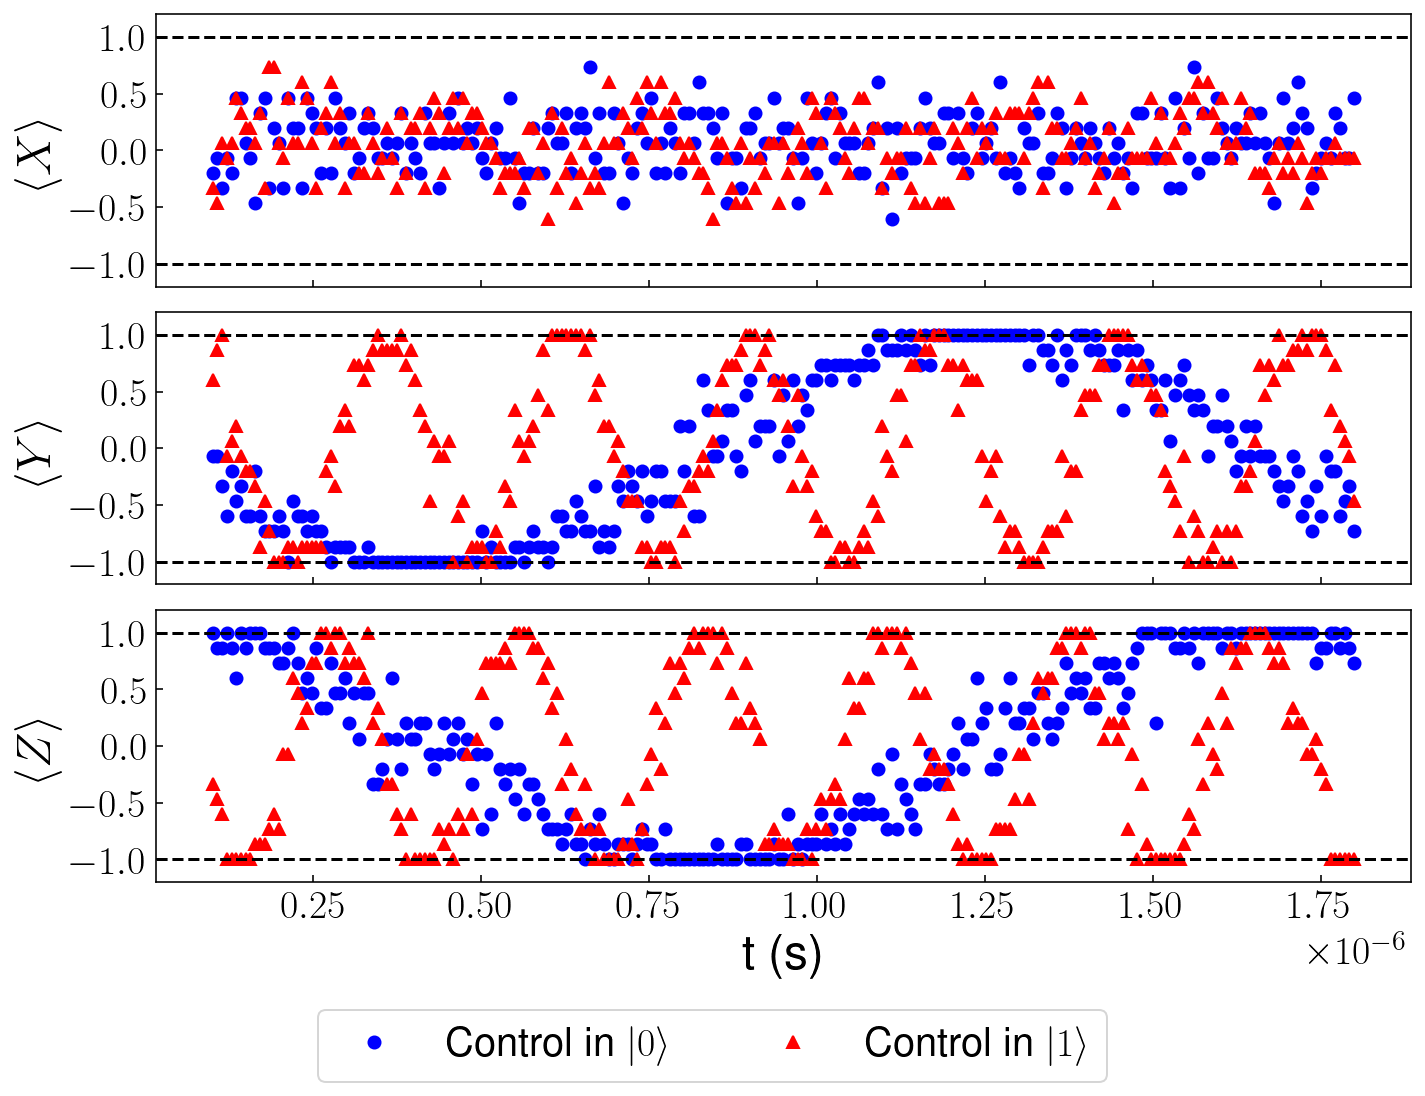

In [142]:
learner_experiment_utils.plot_rabi_oscillations(xi_t*A_cr_expt01.tset, A_cr_expt01.rabi_data())

## 1.2 HAL-FI with Estimator of MLE

In [43]:
# Redefine estimator
est_param_info = {'freq_convert': A_cr.freq_convert, 'xi_t': A_cr.xi_t, 'xi_J': A_cr.xi_J, 'init_J': None}
estimation_strategy = {'baseline': False,
                       'quick_MLE': True,
                       'FLAG_initial_estimate': True, 
                       'FLAG_FFT_high_resolution': False,
                       'FLAG_MLE_param': False, 
                       'FLAG_MLE_J': False}

AL_quick_mle_expt = learner_experiment_utils.Learning_Experiment_Runner(env_cr=env_qs_sim,
                               query_space=query_space, est_param_info=est_param_info, active_learner=HAL_FI_J,
                               FLAG_query_constraints=FLAG_query_constraints, 
                               query_constraints_info=query_constraints_info,
                               estimation_strategy=estimation_strategy,
                               FLAG_adaptive_query_space=FLAG_adaptive_query_space, 
                               adaptive_query_space_info=adaptive_query_space_info,
                               N_0=5*A_cr.N_actions, N_batch=A_cr.N_actions)

In [44]:
i_run = 8
np.random.seed(10 * (i_run + 2))
results_expt02 = AL_quick_mle_expt.AL_runner(verbose=True)

Using quick MLE estimator
FFT + Regression for initial estimation
Solving with query constraints
Upper limits being set
Using quick MLE estimator
FFT + Regression for initial estimation
Solving with query constraints
Upper limits being set
Using quick MLE estimator
FFT + Regression for initial estimation
Solving with query constraints
Upper limits being set
Using quick MLE estimator
FFT + Regression for initial estimation
Solving with query constraints
Upper limits being set
Using quick MLE estimator
FFT + Regression for initial estimation
Solving with query constraints
Upper limits being set
Using quick MLE estimator
FFT + Regression for initial estimation
Solving with query constraints
Upper limits being set
Using quick MLE estimator
FFT + Regression for initial estimation
Solving with query constraints
Upper limits being set
Using quick MLE estimator
FFT + Regression for initial estimation
Solving with query constraints
Upper limits being set
Using quick MLE estimator
FFT + Regressi

In [45]:
# 3. Redefine experiment
est_param_info = {'freq_convert': A_cr.freq_convert, 'xi_t': A_cr.xi_t, 'xi_J': A_cr.xi_J, 'init_J': None}
estimation_strategy = {'baseline': False,
                       'quick_MLE': True,
                       'FLAG_initial_estimate': False, 
                       'FLAG_FFT_high_resolution': False,
                       'FLAG_MLE_param': False, 
                       'FLAG_MLE_J': False}

AL_quick_mle_expt_debug = learner_experiment_utils.Learning_Experiment_Runner(env_cr=env_qs_sim,
                               query_space=query_space, est_param_info=est_param_info, active_learner=HAL_FI_J,
                               FLAG_query_constraints=FLAG_query_constraints, 
                               query_constraints_info=query_constraints_info,
                               estimation_strategy=estimation_strategy,
                               FLAG_adaptive_query_space=FLAG_adaptive_query_space, 
                               adaptive_query_space_info=adaptive_query_space_info,
                               N_0=5*A_cr.N_actions, N_batch=A_cr.N_actions, FLAG_debug_AL=True)

In [46]:
i_run = 8
np.random.seed(10 * (i_run + 2))
results_expt03 = AL_quick_mle_expt_debug.AL_runner(verbose=True)

Using quick MLE estimator
Initial estimate provided
Solving with query constraints
Upper limits being set
Using quick MLE estimator
Initial estimate provided
Solving with query constraints
Upper limits being set
Using quick MLE estimator
Initial estimate provided
Solving with query constraints
Upper limits being set
Using quick MLE estimator
Initial estimate provided
Solving with query constraints
Upper limits being set
Using quick MLE estimator
Initial estimate provided
Solving with query constraints
Upper limits being set
Using quick MLE estimator
Initial estimate provided
Solving with query constraints
Upper limits being set
Using quick MLE estimator
Initial estimate provided
Solving with query constraints
Upper limits being set
Using quick MLE estimator
Initial estimate provided
Solving with query constraints
Upper limits being set
Using quick MLE estimator
Initial estimate provided
Solving with query constraints
Upper limits being set
Using quick MLE estimator
Initial estimate pro

## Summary

In [52]:
results_expt01['N_p']

[7290, 8748, 10206, 11664, 13122, 14580, 16038, 17496, 18954, 20412, 21870]

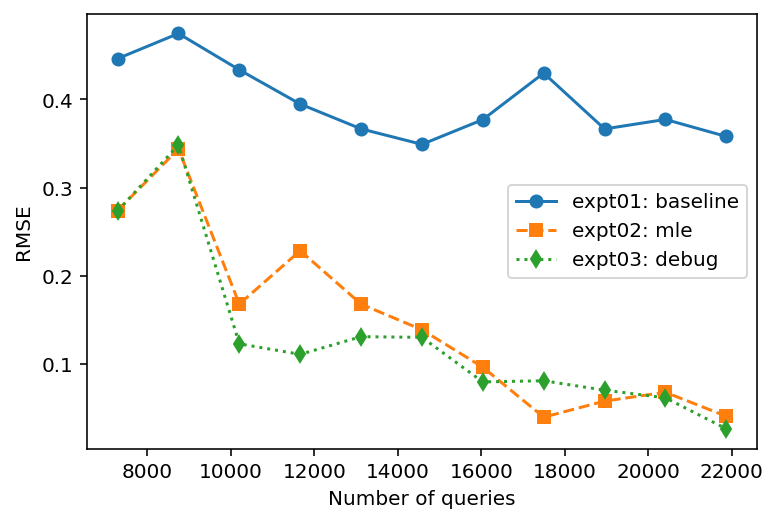

In [64]:
plt.plot(results_expt01['N_p'], np.sqrt(results_expt01['mse']), '-o', label='expt01: baseline')
plt.plot(results_expt02['N_p'], np.sqrt(results_expt02['mse']), '--s', label='expt02: mle')
plt.plot(results_expt03['N_p'], np.sqrt(results_expt03['mse']), ':d', label='expt03: debug')
plt.xlabel('Number of queries')
plt.ylabel('RMSE')
plt.legend()

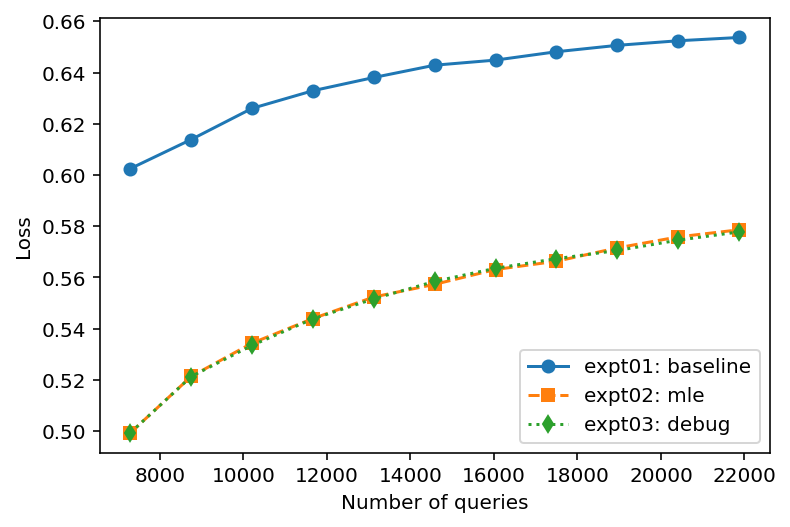

In [66]:
plt.plot(results_expt01['N_p'], results_expt01['loss'], '-o', label='expt01: baseline')
plt.plot(results_expt02['N_p'], results_expt02['loss'], '--s', label='expt02: mle')
plt.plot(results_expt03['N_p'], results_expt03['loss'], ':d', label='expt03: debug')
plt.xlabel('Number of queries')
plt.ylabel('Loss')
plt.legend()

In [67]:
np.sqrt(results_expt01['mse'])

array([0.44622699, 0.47473765, 0.43350706, 0.39472802, 0.36660149,
       0.34903843, 0.37710124, 0.42981909, 0.36653763, 0.37729465,
       0.35797078])

In [68]:
np.sqrt(results_expt02['mse'])

array([0.27397081, 0.34389001, 0.16799997, 0.2285034 , 0.16792548,
       0.13886   , 0.09639059, 0.0397387 , 0.05798831, 0.0679794 ,
       0.0407711 ])

In [69]:
np.sqrt(results_expt03['mse'])

array([0.27363045, 0.34834321, 0.12291479, 0.11098401, 0.13103154,
       0.13025019, 0.07974124, 0.08101247, 0.07036059, 0.06169423,
       0.02654142])

In [70]:
A_cr_expt02 = results_expt02['A_cr']

In [93]:
reload_package(hamiltonianlearner)

Note from the rough simulations carried out here, it seems like that somehow readout noise is not being incorporated properly in our simulations.

In [89]:
75*A_cr_expt02.N_actions

109350

# 3. Minimum Freq. Criteria is not satisfied

In [23]:
# Setup the action space as in the fixed query space
time_stamps_nd = np.linspace(1,6,81)
time_stamps = xi_t*time_stamps_nd
A_cr = simulate_nature.Action_Space(moset, prepset, time_stamps_nd, xi_t, xi_J=xi_J)

In [24]:
# Illustration of different freq_converts
print("freq_convert from sim: %f" %A_cr.freq_convert)
print("freq_convert from expt data: %f" %ibm_data['freq_convert'])

freq_convert from sim: 12411230.236404
freq_convert from expt data: 12466637.514245


In [25]:
query_space = {'moset': moset, 'prepset': prepset, 'time_stamps': time_stamps}

In [26]:
# 2. Define the passive learner
policy_type = 'FI'
FLAG_normalization = True
FLAG_noise = True
growth_time_stamps=None
FLAG_constraints = True

query_constraints_ref = {'N_shots': 512}
FLAG_lower_limits = False

HAL_FI_J = design_experiment.ActiveLearner(policy_type=policy_type,
                                           FLAG_normalization=FLAG_normalization,
                                           FLAG_noise=FLAG_noise,
                                           FLAG_constraints=FLAG_constraints,
                                           query_constraints=query_constraints_ref,
                                           type_param = 'J')

# 3. Define estimator
est_param_info = {'freq_convert': A_cr.freq_convert, 'xi_t': A_cr.xi_t, 'xi_J': A_cr.xi_J, 'init_J': None}
estimation_strategy = {'baseline': True,
                       'quick_MLE': False,
                       'FLAG_initial_estimate': False, 
                       'FLAG_FFT_high_resolution': False,
                       'FLAG_MLE_param': False, 
                       'FLAG_MLE_J': False}

# 4. Define experiment runner
FLAG_query_constraints = True
query_constraints_info = {'query_constraints_ref': None, 'query_optimization_type': 'batch', 'max_iter': 10}
FLAG_adaptive_query_space = False
adaptive_query_space_info = {'growth_time_stamps': 'linear', 'max_iter_growth': 1, 'growth_factor': 1}

AL_baseline_expt = learner_experiment_utils.Learning_Experiment_Runner(env_cr=env_qs_sim,
                               query_space=query_space, est_param_info=est_param_info, active_learner=HAL_FI_J,
                               FLAG_query_constraints=FLAG_query_constraints, 
                               query_constraints_info=query_constraints_info,
                               estimation_strategy=estimation_strategy,
                               FLAG_adaptive_query_space=FLAG_adaptive_query_space, 
                               adaptive_query_space_info=adaptive_query_space_info,
                               N_0=5*A_cr.N_actions, N_batch=A_cr.N_actions)

In [27]:
i_run = 8
np.random.seed(10 * (i_run + 2))
results_expt01 = AL_baseline_expt.AL_runner(verbose=True)

Using baseline estimator
Solving with query constraints
Upper limits being set
Using baseline estimator
Solving with query constraints
Upper limits being set
Using baseline estimator
Solving with query constraints
Upper limits being set
Using baseline estimator
Solving with query constraints
Upper limits being set
Using baseline estimator
Solving with query constraints
Upper limits being set
Using baseline estimator
Solving with query constraints
Upper limits being set
Using baseline estimator
Solving with query constraints
Upper limits being set
Using baseline estimator
Solving with query constraints
Upper limits being set
Using baseline estimator
Solving with query constraints
Upper limits being set
Using baseline estimator
Solving with query constraints
Upper limits being set
Using baseline estimator


In [28]:
results_expt01['J_hat']

[array([-6039313.65480071,  1501234.1185573 , -2540755.44517513,
         6285624.04611588,  2818141.94293797, -1908062.44565495]),
 array([-5958109.94365382,  1250242.08604136, -2428873.57413974,
         6305800.47721001,  3103201.71062622, -1979788.05921226]),
 array([-5956459.10409169,  1178866.09876663, -2495978.88810916,
         6276065.80035464,  3190683.84497684, -1898852.60400669]),
 array([-5913240.15536199,   997579.29337227, -2422083.94547012,
         6262557.40509783,  3362535.91566684, -1979851.06293252]),
 array([-5892213.53079049,  1065015.36938173, -2413990.37490687,
         6300396.89949226,  3335760.14434456, -1942179.98569203]),
 array([-5874525.34781788,  1144222.68642262, -2434650.06101076,
         6335264.04130464,  3299196.01392547, -1872716.78022518]),
 array([-5843295.09978591,   992272.32454165, -2391487.21700396,
         6316156.58004586,  3436295.69906585, -1929837.38038808]),
 array([-5826727.83490467,   975605.92771828, -2469088.7182757 ,
         63

In [29]:
A_cr_expt01 = results_expt01['A_cr']

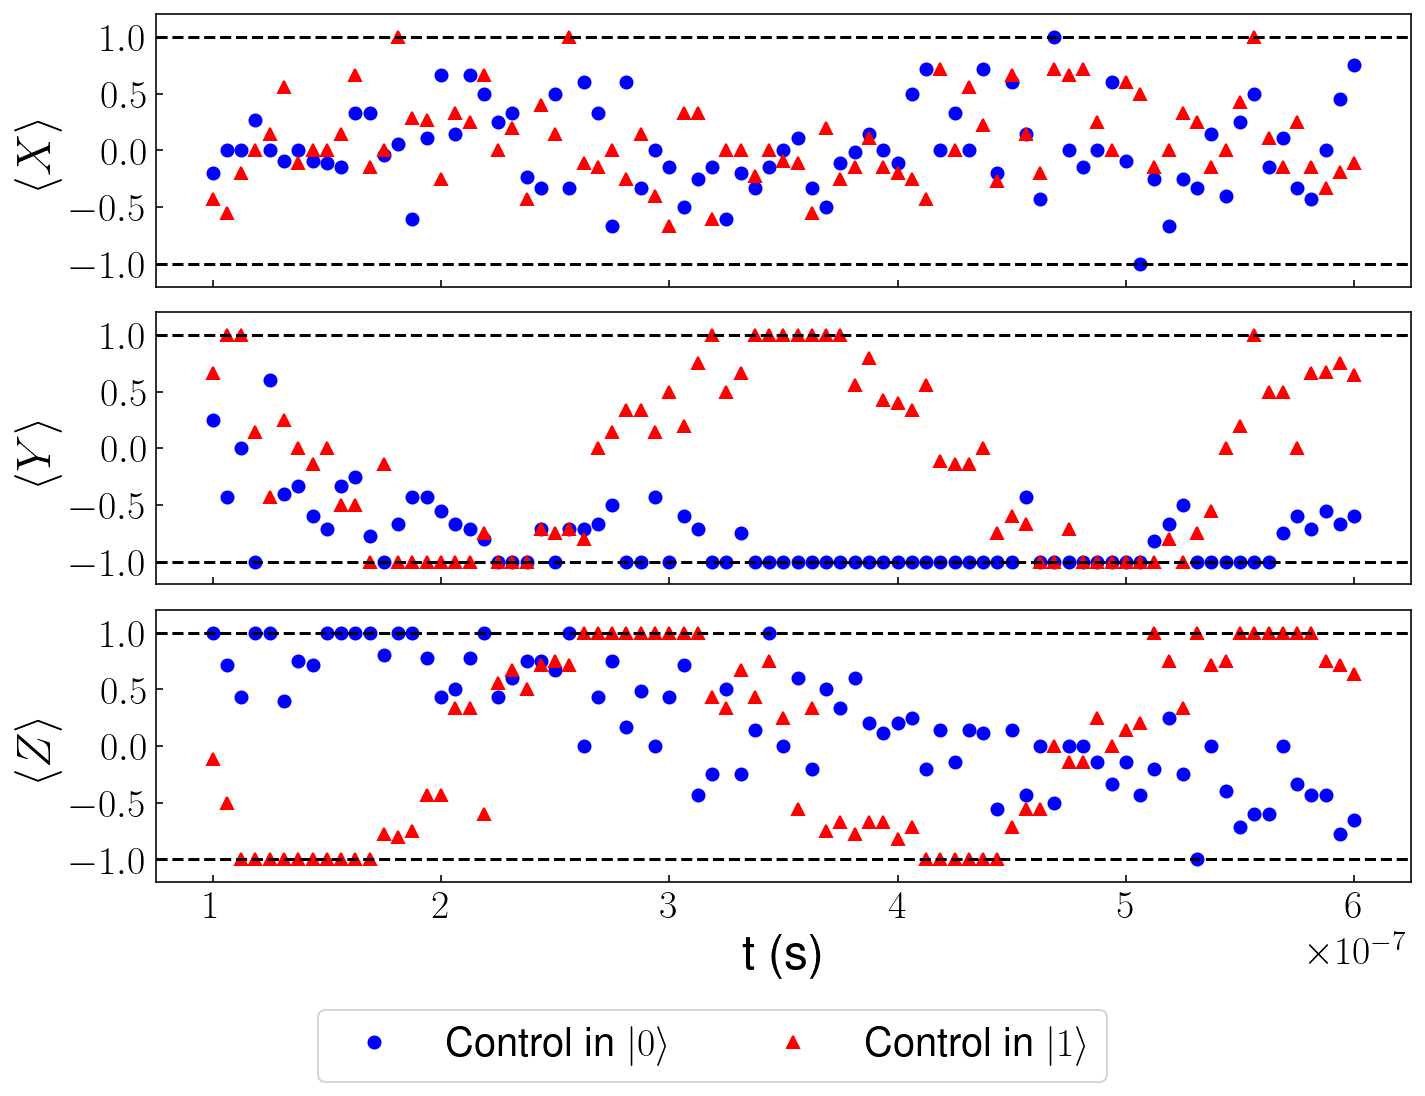

In [30]:
learner_experiment_utils.plot_rabi_oscillations(xi_t*A_cr_expt01.tset, A_cr_expt01.rabi_data())

In [31]:
# 3. Redefine estimator
est_param_info = {'freq_convert': A_cr.freq_convert, 'xi_t': A_cr.xi_t, 'xi_J': A_cr.xi_J, 'init_J': None}
estimation_strategy = {'baseline': False,
                       'quick_MLE': True,
                       'FLAG_initial_estimate': True, 
                       'FLAG_FFT_high_resolution': False,
                       'FLAG_MLE_param': False, 
                       'FLAG_MLE_J': False}

AL_quick_mle_expt = learner_experiment_utils.Learning_Experiment_Runner(env_cr=env_qs_sim,
                               query_space=query_space, est_param_info=est_param_info, active_learner=HAL_FI_J,
                               FLAG_query_constraints=FLAG_query_constraints, 
                               query_constraints_info=query_constraints_info,
                               estimation_strategy=estimation_strategy,
                               FLAG_adaptive_query_space=FLAG_adaptive_query_space, 
                               adaptive_query_space_info=adaptive_query_space_info,
                               N_0=5*A_cr.N_actions, N_batch=A_cr.N_actions)

In [32]:
i_run = 8
np.random.seed(10 * (i_run + 2))
results_expt02 = AL_quick_mle_expt.AL_runner(verbose=True)

Using quick MLE estimator
FFT + Regression for initial estimation
Solving with query constraints
Upper limits being set
Using quick MLE estimator
FFT + Regression for initial estimation
Solving with query constraints
Upper limits being set
Using quick MLE estimator
FFT + Regression for initial estimation
Solving with query constraints
Upper limits being set
Using quick MLE estimator
FFT + Regression for initial estimation
Solving with query constraints
Upper limits being set
Using quick MLE estimator
FFT + Regression for initial estimation
Solving with query constraints
Upper limits being set
Using quick MLE estimator
FFT + Regression for initial estimation
Solving with query constraints
Upper limits being set
Using quick MLE estimator
FFT + Regression for initial estimation
Solving with query constraints
Upper limits being set
Using quick MLE estimator
FFT + Regression for initial estimation
Solving with query constraints
Upper limits being set
Using quick MLE estimator
FFT + Regressi

In [33]:
# 3. Redefine experiment
est_param_info = {'freq_convert': A_cr.freq_convert, 'xi_t': A_cr.xi_t, 'xi_J': A_cr.xi_J, 'init_J': None}
estimation_strategy = {'baseline': False,
                       'quick_MLE': True,
                       'FLAG_initial_estimate': False, 
                       'FLAG_FFT_high_resolution': False,
                       'FLAG_MLE_param': False, 
                       'FLAG_MLE_J': False}

AL_quick_mle_expt_debug = learner_experiment_utils.Learning_Experiment_Runner(env_cr=env_qs_sim,
                               query_space=query_space, est_param_info=est_param_info, active_learner=HAL_FI_J,
                               FLAG_query_constraints=FLAG_query_constraints, 
                               query_constraints_info=query_constraints_info,
                               estimation_strategy=estimation_strategy,
                               FLAG_adaptive_query_space=FLAG_adaptive_query_space, 
                               adaptive_query_space_info=adaptive_query_space_info,
                               N_0=5*A_cr.N_actions, N_batch=A_cr.N_actions, FLAG_debug_AL=True)

In [34]:
i_run = 8
np.random.seed(10 * (i_run + 2))
results_expt03 = AL_quick_mle_expt_debug.AL_runner(verbose=True)

Using quick MLE estimator
Initial estimate provided
Solving with query constraints
Upper limits being set
Using quick MLE estimator
Initial estimate provided
Solving with query constraints
Upper limits being set
Using quick MLE estimator
Initial estimate provided
Solving with query constraints
Upper limits being set
Using quick MLE estimator
Initial estimate provided
Solving with query constraints
Upper limits being set
Using quick MLE estimator
Initial estimate provided
Solving with query constraints
Upper limits being set
Using quick MLE estimator
Initial estimate provided
Solving with query constraints
Upper limits being set
Using quick MLE estimator
Initial estimate provided
Solving with query constraints
Upper limits being set
Using quick MLE estimator
Initial estimate provided
Solving with query constraints
Upper limits being set
Using quick MLE estimator
Initial estimate provided
Solving with query constraints
Upper limits being set
Using quick MLE estimator
Initial estimate pro

Summary

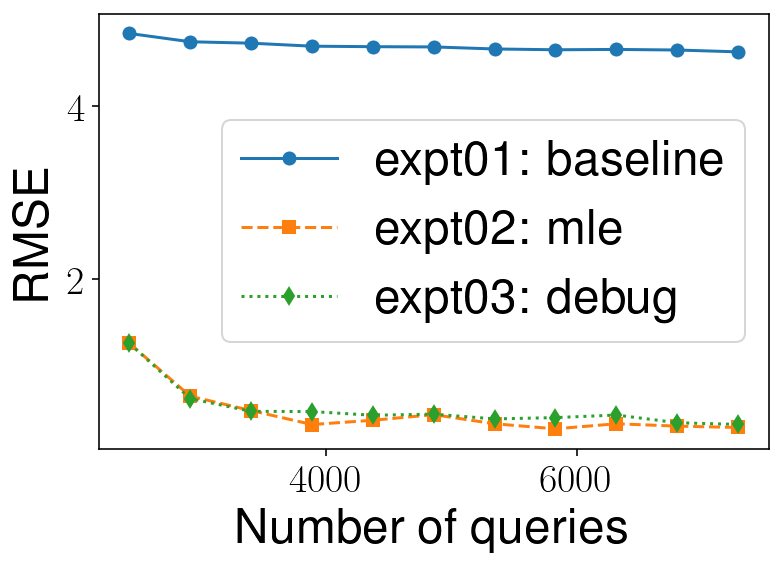

In [35]:
plt.plot(results_expt01['N_p'], np.sqrt(results_expt01['mse']), '-o', label='expt01: baseline')
plt.plot(results_expt02['N_p'], np.sqrt(results_expt02['mse']), '--s', label='expt02: mle')
plt.plot(results_expt03['N_p'], np.sqrt(results_expt03['mse']), ':d', label='expt03: debug')
plt.xlabel('Number of queries')
plt.ylabel('RMSE')
plt.legend()

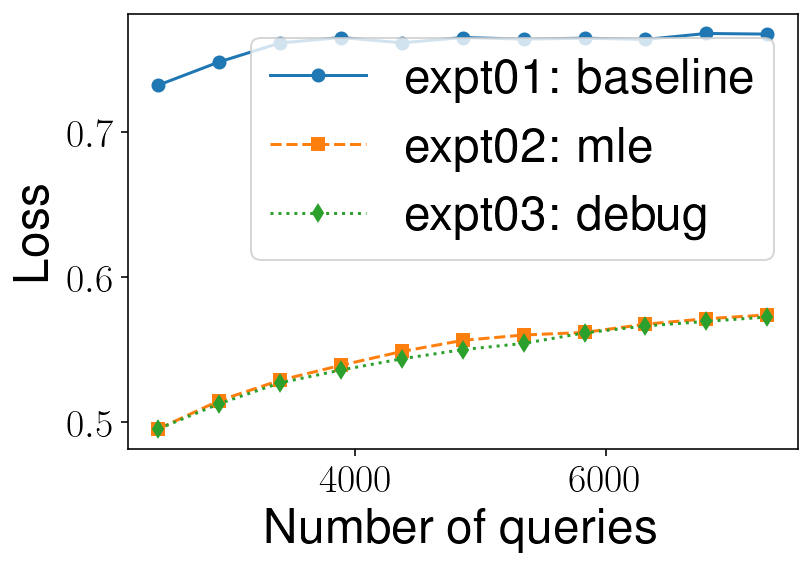

In [36]:
plt.plot(results_expt01['N_p'], results_expt01['loss'], '-o', label='expt01: baseline')
plt.plot(results_expt02['N_p'], results_expt02['loss'], '--s', label='expt02: mle')
plt.plot(results_expt03['N_p'], results_expt03['loss'], ':d', label='expt03: debug')
plt.xlabel('Number of queries')
plt.ylabel('Loss')
plt.legend()

In [39]:
np.sqrt(results_expt02['mse'])

array([1.25045799, 0.63733431, 0.47054266, 0.30838778, 0.35776209,
       0.42280079, 0.31697668, 0.25861422, 0.31720319, 0.2896373 ,
       0.27397634])

In [44]:
255*486

123930

In [40]:
512*486

248832